In [1]:
# Dependencies
import requests
from pprint import pprint
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress, pearsonr
import scipy.stats as stats
import scipy
import numpy as np
from scipy.optimize import curve_fit
import math
import gmaps
from scipy.stats import boxcox



from config import gkey
# Configure gmaps
gmaps.configure(api_key=gkey)

# Calling the dataset from the API

In [2]:
# Calling the API
url = "https://api.covid19api.com/all"

response1 = requests.get(url).json()
response1

country = []
date = []
total_cases = []
total_deaths = []
total_recovered = []

for row in response1:
    country.append(row['Country'])
    date.append(row["Date"])
    total_cases.append(row['Confirmed'])
    total_deaths.append(row['Deaths'])
    total_recovered.append(row['Recovered'])
    

In [3]:
#creating the dataframe
covid_new_df1 = pd.DataFrame({
                            'Country': country,
                            'Date': date,
                            'Total Cases': total_cases,
                            'Total Deaths': total_deaths,
                            'Total Recovered': total_recovered
})


In [4]:
#counting the number of rows
len(covid_new_df1)

658052

In [5]:
#recognizing the data types
covid_new_df1.dtypes

Country            object
Date               object
Total Cases         int64
Total Deaths        int64
Total Recovered     int64
dtype: object

# Cleaning the data

In [6]:
# cleaning the data for the US
US_df=covid_new_df1.loc[(covid_new_df1["Country"]=='United States of America')]
new_us_df=US_df.groupby('Date').max().reset_index()
covid_new_df1=covid_new_df1.loc[(covid_new_df1["Country"]!='United States of America')]
frames=[covid_new_df1,new_us_df]
covid_new_df1 = pd.concat(frames)
covid_new_df1.head()

Country                  Date  Total Cases  Total Deaths  \
0  Afghanistan  2020-01-22T00:00:00Z            0             0   
1  Afghanistan  2020-01-23T00:00:00Z            0             0   
2  Afghanistan  2020-01-24T00:00:00Z            0             0   
3  Afghanistan  2020-01-25T00:00:00Z            0             0   
4  Afghanistan  2020-01-26T00:00:00Z            0             0   

   Total Recovered  
0                0  
1                0  
2                0  
3                0  
4                0

In [7]:
#change dateformats from objects to date time format 
covid_new_df1.loc[:,'Date']=pd.to_datetime(covid_new_df1.loc[:,"Date"]).apply(lambda x: x.date())
clean_covid19=covid_new_df1
clean_covid19.to_csv('Resources/clean_covid19_from_API')


In [8]:
#since our data from the API is updated daily and hence is dynamic. so any day this is ran, the results may vary. please be minful of that!
number_of_countries=clean_covid19['Country'].value_counts()
days=len(clean_covid19['Date'].value_counts())
days

183

# Analysing the Dataframe

In [9]:
#grouping by date and summing up the global data for each date
grouped_data = covid_new_df1.groupby("Date").sum()
grouped_data_df = grouped_data.reset_index()
grouped_data_df.head()

Date  Total Cases  Total Deaths  Total Recovered
0  2020-01-22          555            17               28
1  2020-01-23          654            18               30
2  2020-01-24          941            26               36
3  2020-01-25         1434            42               39
4  2020-01-26         2118            56               52

In [10]:
#dropping the NAN values
grouped_data1=grouped_data.dropna()
grouped_data1

Total Cases  Total Deaths  Total Recovered
Date                                                  
2020-01-22          555            17               28
2020-01-23          654            18               30
2020-01-24          941            26               36
2020-01-25         1434            42               39
2020-01-26         2118            56               52
...                 ...           ...              ...
2020-07-18     14292208        602130          8045164
2020-07-19     14506855        606159          8133041
2020-07-20     14713633        610207          8292037
2020-07-21     14947088        616431          8466527
2020-07-22     15226801        623369          8640646

[183 rows x 3 columns]

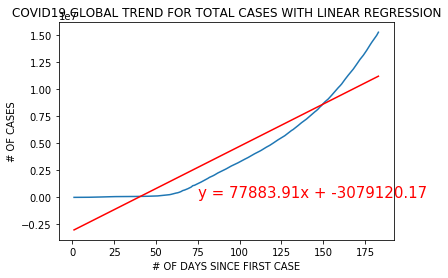

In [37]:
#plotting the global trend for Total cases and the linear regression
test = grouped_data1.reset_index().reset_index()

test["index"] = test["index"] + 1
plt.plot(test["index"], test["Total Cases"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(test["index"], test["Total Cases"])
regress_values = test["index"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(test["index"], regress_values,"r-")
plt.annotate(line_eq,(75,10),fontsize=15,color="red")
plt.title("COVID19 GLOBAL TREND FOR TOTAL CASES WITH LINEAR REGRESSION")
plt.xlabel("# OF DAYS SINCE FIRST CASE")
plt.ylabel("# OF CASES")
plt.savefig('output/covid19_fig1')
plt.show()


For COVID-19, Total cases is15134140 and Total Deaths is620018; so the death rate is %4.1


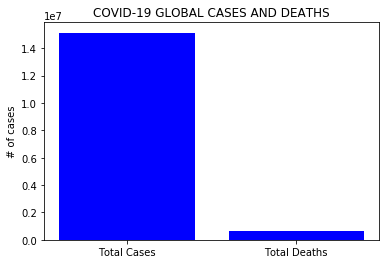

In [12]:
# covid-19 Cases and Deaths bar chart
global_total = clean_covid19.groupby(['Country'])['Total Cases'].max().sum()
global_death = clean_covid19.groupby(['Country'])['Total Deaths'].max().sum()
print(f'For COVID-19, Total cases is{global_total} and Total Deaths is{global_death}; so the death rate is %{round(global_death/global_total*100,2)}')
global_data = [global_total, global_death]
xaxis = np.arange(len(global_data))
plt.bar(xaxis, global_data, color='b', alpha=1, align="center", tick_label=("Total Cases", "Total Deaths"))
plt.title("COVID-19 GLOBAL CASES AND DEATHS")
plt.ylabel("# of cases")
plt.savefig('output/covid19_fig2')
plt.show()

REGRESSION VALUE= 1.0 *x**3 + 340.81*x**2 + -14044.3*x +73709.58


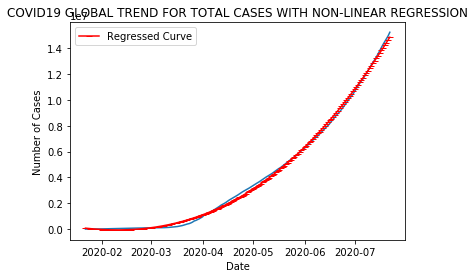

The predicted number of cases after 365 days from the start of the year based on our regression will be 89035877


<Figure size 432x288 with 0 Axes>

In [13]:
##plotting the global trend for Total cases and the nonlinear regression

#Performing regression
x=np.arange(0,days)
y=grouped_data_df["Total Cases"]
# create a function to fit with your data. a, b, c and d are the coefficients
# that curve_fit will calculate for you. 
# In this part you need to guess and/or use mathematical knowledge to find
# a function that resembles your data

def func(x, a, b, c, d):
    return a*x**3 + b*x**2 +c*x + d

# make the curve_fit
popt, pcov = curve_fit(func, x, y)

# The result is:
a=popt[0]
b=popt[1]
c=popt[2]
d=popt[3] 

# Print the coefficients and plot the funcion.
line_eq=print(f'REGRESSION VALUE= {round(a,2)} *x**3 + {round(b,2)}*x**2 + {round(c,2)}*x +{ round(d,2)}')

#plt data and fitted graph together

x=np.arange(0,days)
plt.plot(grouped_data_df["Date"],grouped_data_df["Total Cases"])
regress_value = popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3]
plt.plot(grouped_data_df["Date"], popt[0]*x**3 + popt[1]*x**2 + popt[2]*x + popt[3], label="Regressed Curve",color='r',marker='_') 
plt.annotate(line_eq,(50,10000000))
plt.legend(loc='upper left')
plt.title('COVID19 GLOBAL TREND FOR TOTAL CASES WITH NON-LINEAR REGRESSION')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()

#save the figure in the output folder
plt.savefig('output/covid19_fig2')

#make the predictions for d days from the start of 2020
d=365
predicted_value= int(popt[0]*d**3 + popt[1]*d**2 + popt[2]*d + popt[3])
print(f'The predicted number of cases after {d} days from the start of the year based on our regression will be {predicted_value}')
plt.savefig('output/covid19_fig3')

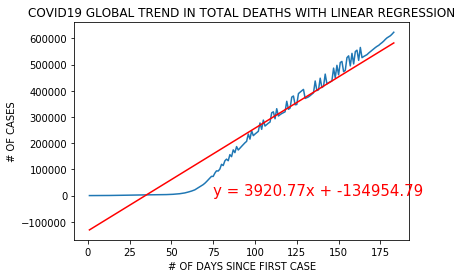

In [14]:
#plotting the global trend for Total Deaths and the linear regression
test = grouped_data1.reset_index().reset_index()

test["index"] = test["index"] + 1
plt.plot(test["index"], test["Total Deaths"])
(slope, intercept, rvalue, pvalue, stderr) = linregress(test["index"], test["Total Deaths"])
regress_values = test["index"] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(test["index"], regress_values,"r-")
plt.annotate(line_eq,(75,10),fontsize=15,color="red")
plt.title("COVID19 GLOBAL TREND IN TOTAL DEATHS WITH LINEAR REGRESSION")
plt.xlabel("# OF DAYS SINCE FIRST CASE")
plt.ylabel("# OF CASES")
plt.savefig('output/covid19_fig4')

REGRESSION VALUE= 16.33 *x**2 + 948.51*x + -41370.86
The predicted number of deaths after 365 days from the start of the year based on our regression will be 2480546


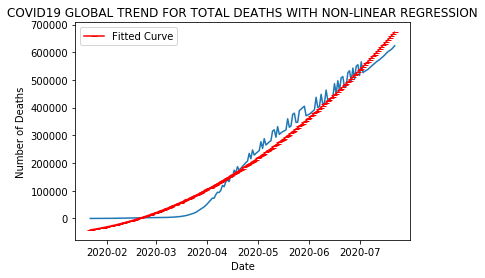

In [15]:

#plotting the global trend for Total Deaths

# plt.plot(grouped_data_df["Date"],grouped_data_df["Total Deaths"])

plt.savefig('output/covid19_fig1')



# Performing regression
x=np.arange(0,days)
y=grouped_data_df["Total Deaths"]
# create a function to fit with your data. a, b, c are the coefficients
# that curve_fit will calculate for you. 
# In this part you need to guess and/or use mathematical knowledge to find
# a function that resembles your data

def func(x, a, b, c):
    return a*x**2 + b*x +c

# make the curve_fit
popt, pcov = curve_fit(func, x, y)

# The result is:
a=popt[0]
b=popt[1]
c=popt[2]

# # Print the coefficients and plot the funcion.

line_eq=print(f'REGRESSION VALUE= {round(a,2)} *x**2 + {round(b,2)}*x + {round(c,2)}')
line_eq

# # Print the coefficients and plot the funcion.

plt.plot(grouped_data_df["Date"],grouped_data_df["Total Deaths"])
regress_value = popt[0]*x**2+ popt[1]*x**1 + popt[2]
plt.plot(grouped_data_df["Date"], popt[0]*x**2 + popt[1]*x**1 + popt[2], label="Fitted Curve",color='r',marker='_') 
plt.annotate(line_eq,(100,0),c='y')
plt.legend(loc='upper left')
plt.title('COVID19 GLOBAL TREND FOR TOTAL DEATHS WITH NON-LINEAR REGRESSION')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.savefig('output/covid19_fig2')
d=365
predicted_value= round(int(popt[0]*d**2 + popt[1]*d**1 + popt[2]),0)

print(f'The predicted number of deaths after {d} days from the start of the year based on our regression will be {predicted_value}')
plt.savefig('output/covid19_fig5')

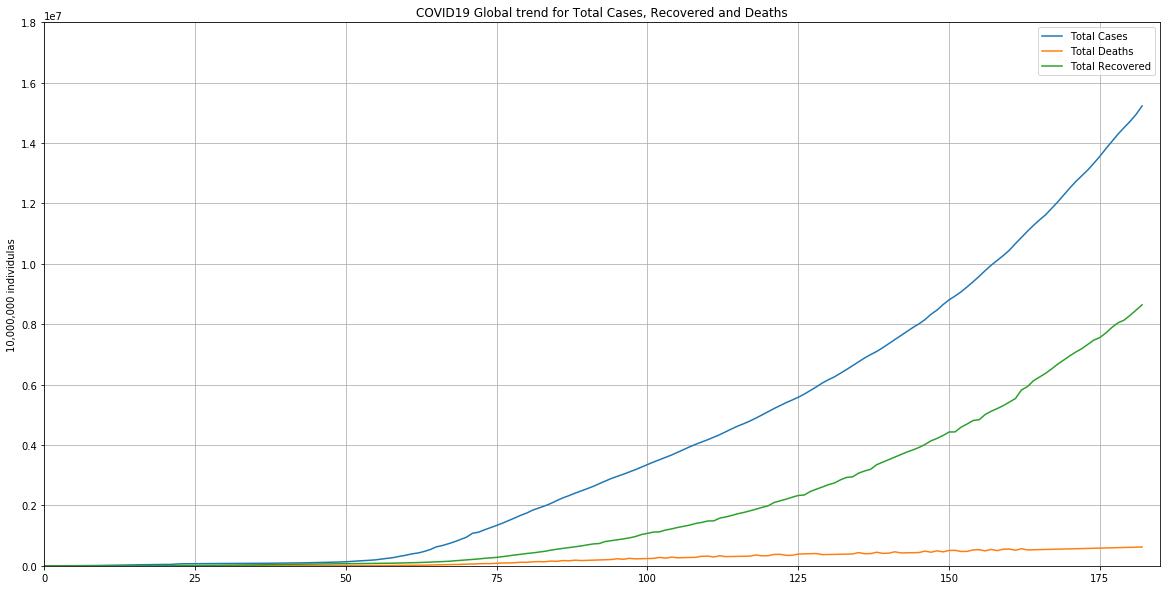

In [16]:
#plotting the global trend for Total cases, Recovered and Deaths
grouped_data_df.plot(kind='line',figsize=(20,10))
plt.grid()
plt.xlim(0,185)
plt.ylim(0,18000000)
plt.title('COVID19 Global trend for Total Cases, Recovered and Deaths' )
plt.ylabel('10,000,000 individulas')
plt.savefig('output/covid19_fig6')


In [17]:
#groupby countries and  calculate the latest stats
total_cases_per_country=covid_new_df1.groupby('Country')['Total Cases'].max()
total_recovered_per_country=covid_new_df1.groupby('Country')['Total Recovered'].max()
total_deaths_per_country=covid_new_df1.groupby('Country')['Total Deaths'].max()
a=total_cases_per_country.reset_index().iloc[:,1]
b=total_recovered_per_country.reset_index().iloc[:,1]
c=total_deaths_per_country.reset_index().iloc[:,1]

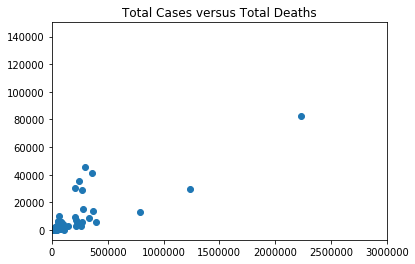

(0.9337627997925686, 4.8846972165772175e-84)

In [18]:
#scatter plot of the total cases vs total deaths for all the countries
plt.scatter(a,c)
plt.title('Total Cases versus Total Deaths')
plt.savefig('output/covid19_fig8')
plt.xlim(0,3000000)
plt.show()
#calculating the coefficient
coefficient=pearsonr(a,c)
coefficient

In [19]:
#top10_cases_per_country: governmental protection plans
top10_latest_cases=total_cases_per_country.sort_values(ascending=False).iloc[0:10]
top10_latest_cases

Country
United States of America     3970906
Brazil                       2227514
India                        1238798
Russian Federation            787890
South Africa                  394948
Peru                          366550
Mexico                        362274
Chile                         334683
United Kingdom                296377
Iran, Islamic Republic of     281413
Name: Total Cases, dtype: int64

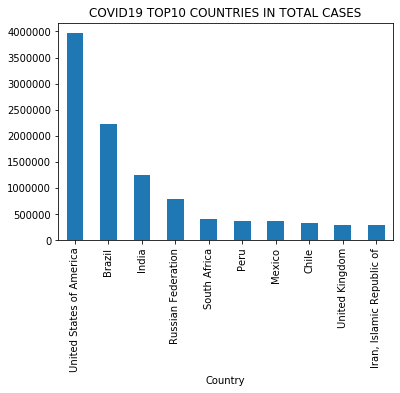

In [20]:
#plotting a bar chart for the top10 cases
top10_latest_cases.plot(kind='bar')
plt.title('COVID19 TOP10 COUNTRIES IN TOTAL CASES')
plt.savefig('output/covid19_fig9')
plt.show()

In [21]:
#top10_recovered_per_country: country's health care system efficiency
top10_latest_recovered=total_recovered_per_country.sort_values(ascending=False).iloc[0:10]


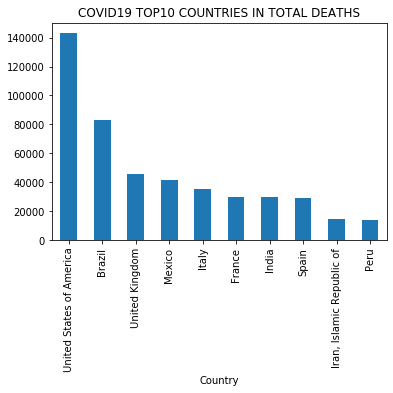

In [22]:
#top10_deaths_per_country
top10_latest_deaths=total_deaths_per_country.sort_values(ascending=False).iloc[0:10]
top10_latest_deaths.plot(kind='bar')
#plotting a bar chart for top10 countries by total death 
plt.title('COVID19 TOP10 COUNTRIES IN TOTAL DEATHS')
plt.savefig('output/covid19_fig10')
plt.show()

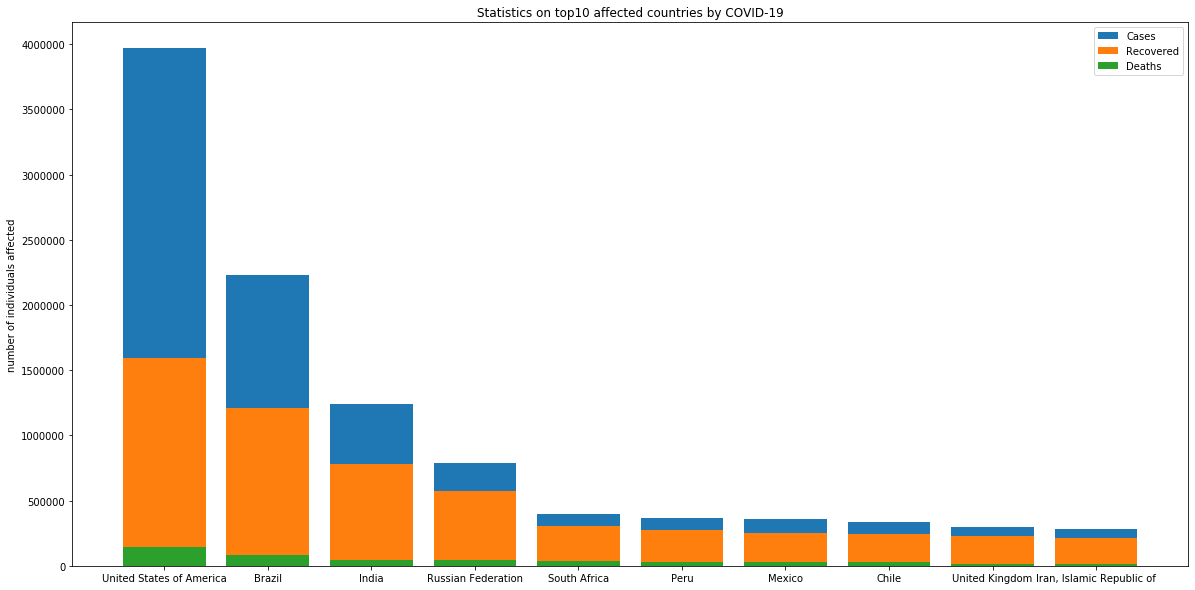

The Death Rate in United States of America is %3.61
The Death Rate in Brazil is %3.72
The Death Rate in India is %3.67
The Death Rate in Russian Federation is %5.23
The Death Rate in South Africa is %8.88
The Death Rate in Peru is %8.2
The Death Rate in Mexico is %8.24
The Death Rate in Chile is %8.59
The Death Rate in United Kingdom is %5.01
The Death Rate in Iran, Islamic Republic of is %4.89


In [23]:
# stacked bar graph of top most affected countries
f, ax = plt.subplots(figsize=(20,10))
x=top10_latest_cases.reset_index()["Country"]
y=top10_latest_cases.reset_index().iloc[:,1]
z=top10_latest_recovered.reset_index().iloc[:,1]
q=top10_latest_deaths.reset_index().iloc[:,1]
plt.bar(x,y,label='Cases')
plt.bar(x,z,label = 'Recovered')
plt.bar(x,q,label = 'Deaths')
plt.legend()
plt.title('Statistics on top10 affected countries by COVID-19')
plt.ylabel('number of individuals affected')
plt.savefig('output/covid19_fig11')
plt.show()
#calculating the death percentage per country
for i in np.arange(0,10):
    print(f'The Death Rate in {x[i]} is %{round(q[i]/y[i]*100,2)}')


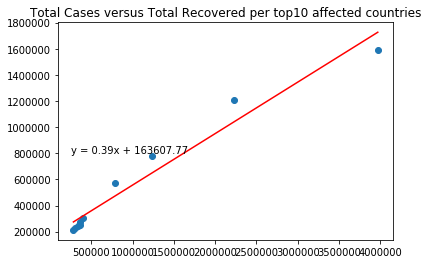

(0.9791011180632817, 8.138358658595495e-07)

In [24]:
#scatter plot cases vs recovered for top10 countries with the linear regression

plt.scatter(y,z)
# linear regression on cases vs recovered
(slope, intercept, rvalue, pvalue, stderr) = linregress(y, z)
recovered_slope=slope
regress_value=slope*y+intercept
recovered_line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(recovered_line_eq,(250000,800000))
plt.plot(y, regress_value, 'r', label='fitted line')
plt.title('Total Cases versus Total Recovered per top10 affected countries')
plt.savefig('output/covid19_fig12')
plt.show()
#calculating the coefficient
coefficient=pearsonr(y,z)
coefficient

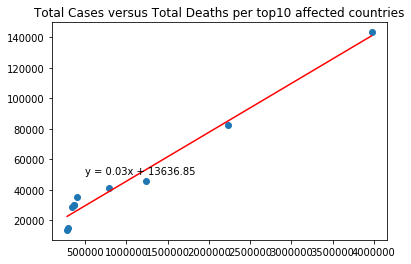

(0.9866695946549351, 1.3595252129812832e-07)

In [25]:
#scatter plot cases vs recovered_per country

plt.scatter(y,q)
# linear regression on cases vs deaths
(slope, intercept, rvalue, pvalue, stderr) = linregress(y, q)
death_slope=slope
regress_value=slope*y+intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq,(500000,50000))
plt.plot(y, regress_value, 'r', label='fitted line')
plt.title('Total Cases versus Total Deaths per top10 affected countries')
plt.savefig('output/covid19_fig13')
plt.show()
#calculating the coefficient
coefficient=pearsonr(y,q)
coefficient


# Gmaps

In [26]:
grouped_df = clean_covid19.groupby("Country").sum()
grouped_df


Total Cases  Total Deaths  Total Recovered
Country                                                   
Afghanistan         1756025         42886           673917
Albania              173386          5041           105682
Algeria             1046018         72248           666158
Andorra               89917          5163            65059
Angola                18133           890             5370
...                     ...           ...              ...
Viet Nam              38580             0            31013
Western Sahara          851            58              608
Yemen                 58806         15341            19828
Zambia               108415          1955            73139
Zimbabwe              38724           717             9605

[186 rows x 3 columns]

In [27]:
grouped_df.reset_index(inplace=True)
grouped_df

Country  Total Cases  Total Deaths  Total Recovered
0       Afghanistan      1756025         42886           673917
1           Albania       173386          5041           105682
2           Algeria      1046018         72248           666158
3           Andorra        89917          5163            65059
4            Angola        18133           890             5370
..              ...          ...           ...              ...
181        Viet Nam        38580             0            31013
182  Western Sahara          851            58              608
183           Yemen        58806         15341            19828
184          Zambia       108415          1955            73139
185        Zimbabwe        38724           717             9605

[186 rows x 4 columns]

In [28]:
params = {"key": gkey}


for i,row in grouped_df.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    country = row['Country']
    params['address'] = f"{country}"
    try:
        response = requests.get(base_url, params=params).json()    
        grouped_df.loc[i, 'Lat'] = response["results"][0]["geometry"]["location"]["lat"]
        grouped_df.loc[i, 'Lng'] = response["results"][0]["geometry"]["location"]["lng"]

    except:
        print(f"{country} not found. skipping....")
        pass

grouped_df.head(20)

Country  Total Cases  Total Deaths  Total Recovered  \
0           Afghanistan      1756025         42886           673917   
1               Albania       173386          5041           105682   
2               Algeria      1046018         72248           666158   
3               Andorra        89917          5163            65059   
4                Angola        18133           890             5370   
5   Antigua and Barbuda         4079           311             2297   
6             Argentina      3660835         83349          1340647   
7               Armenia      1402695         23593           727118   
8             Australia       888061         10671           666711   
9               Austria      1933305         67831          1547816   
10           Azerbaijan       986296         12243           592873   
11              Bahamas        10460          1148             5592   
12              Bahrain      1561392          4427          1158545   
13           Bangladesh      7649105        101229          3102863   
14             Barbados        10110           703             6974   
15              Belarus      4091840         25746          2471722   
16              Belgium      5952889        914586          1540414   
17               Belize         2397           212             1489   
18                Benin        55784           923            21085   
19               Bhutan         4501             0             2414   

          Lat         Lng  
0   33.939110   67.709953  
1   41.153332   20.168331  
2   28.033886    1.659626  
3   42.506285    1.521801  
4  -11.202692   17.873887  
5   17.060816  -61.796428  
6  -38.416097  -63.616672  
7   40.069099   45.038189  
8  -25.274398  133.775136  
9   47.516231   14.550072  
10  40.143105   47.576927  
11  25.034280  -77.396280  
12  26.066700   50.557700  
13  23.684994   90.356331  
14  13.193887  -59.543198  
15  53.709807   27.953389  
16  50.503887    4.469936  
17  17.189877  -88.497650  
18   9.307690    2.315834  
19  27.514162   90.433601

In [29]:
locations = grouped_df[["Lat", "Lng"]]

rating = grouped_df["Total Cases"]
# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations,weights=rating, 
                                 dissipating=False, max_intensity=100,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

# Statistical Analysis

- We tried Mannwhitneyu method to test the hypothesis.
- We also tried to transform the data into normal distribution.

In [30]:
h1n1_df = pd.read_csv('Resources/H1N1_dataset.csv')
grouped_h1n1 = h1n1_df.groupby("Country").sum()
mean_h1n1 = grouped_h1n1['Cumulative no. of cases'].mean()
print(mean_h1n1)

covid_grouped_df = clean_covid19.groupby("Country").sum()
mean_covid = covid_grouped_df['Total Cases'].mean()
print(mean_covid)

6575.560810810811
4020293.2419354836


(array([143.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([1.000000e+00, 4.185410e+04, 8.370720e+04, 1.255603e+05,
        1.674134e+05, 2.092665e+05, 2.511196e+05, 2.929727e+05,
        3.348258e+05, 3.766789e+05, 4.185320e+05]),
 <a list of 10 Patch objects>)

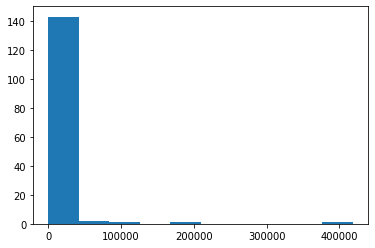

In [31]:
population1 = grouped_h1n1['Cumulative no. of cases']
population2 = covid_grouped_df['Total Cases']
plt.hist(population1)

(array([179.,   4.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([8.51000000e+02, 2.03499893e+07, 4.06991276e+07, 6.10482659e+07,
        8.13974042e+07, 1.01746542e+08, 1.22095681e+08, 1.42444819e+08,
        1.62793957e+08, 1.83143096e+08, 2.03492234e+08]),
 <a list of 10 Patch objects>)

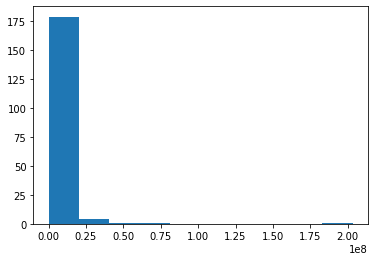

In [32]:
plt.hist(population2)

In [33]:
test = stats.mannwhitneyu(population1,population2)
test

MannwhitneyuResult(statistic=702.0, pvalue=1.6425922686397164e-50)

(array([22., 19., 26., 22., 19., 17., 12.,  5.,  4.,  2.]),
 array([ 0.        ,  1.29445086,  2.58890173,  3.88335259,  5.17780345,
         6.47225431,  7.76670518,  9.06115604, 10.3556069 , 11.65005777,
        12.94450863]),
 <a list of 10 Patch objects>)

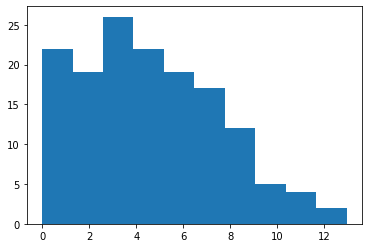

In [34]:
data1 = boxcox(population1,0)
plt.hist(data1)

(array([12.,  8., 15., 37., 38., 24., 29., 12.,  9.,  2.]),
 array([ 6.74641213,  7.98488476,  9.22335738, 10.46183001, 11.70030264,
        12.93877526, 14.17724789, 15.41572052, 16.65419315, 17.89266577,
        19.1311384 ]),
 <a list of 10 Patch objects>)

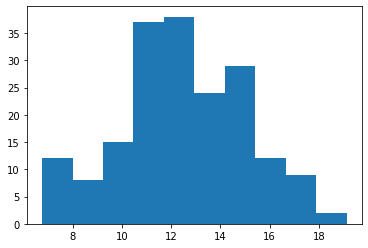

In [35]:
data2 = boxcox(population2,0)
plt.hist(data2)

In [36]:
stats.ttest_ind(data, data2, equal_var=False)

NameError: name 'data' is not defined